In [62]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.linear_model import LogisticRegression,Lasso,LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import datetime
from scipy.stats import zscore
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import operator
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [3]:
#Creating a database of dates from initial value of 12th April till now for fetching the data
import datetime
from datetime import date, timedelta

DATE=[]

date_start = datetime.datetime(2020, 4, 12)
date_end = datetime.datetime.now()

delta = date_end - date_start

for i in range(delta.days + 1):
    day = date_start + timedelta(days=i)
    DATE.append(day.strftime("%m-%d-%Y"))

In [ ]:
#Fetching the data from online and saing in the pandas format
a= "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/"

df = pd.read_csv((a+DATE[0]+".csv"),error_bad_lines=False)

for i in range(1,len(DATE)):
    try:
        df_1 = pd.read_csv((a+DATE[i]+".csv"),error_bad_lines=False)
        df = pd.concat([df, df_1])
    except:
        pass
    
df.head()

In [ ]:
#Saving the updated file in csv format 
df.to_csv("Covid_All.csv",index=False)

In [2]:
#Reading the csv file again
df = pd.read_csv("Covid_All.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13416 entries, 0 to 13415
Data columns (total 20 columns):
Active                  13399 non-null float64
Case_Fatality_Ratio     1140 non-null float64
Confirmed               13416 non-null int64
Country_Region          13416 non-null object
Deaths                  13416 non-null int64
FIPS                    13397 non-null float64
Hospitalization_Rate    5129 non-null float64
ISO3                    13416 non-null object
Incident_Rate           12936 non-null float64
Last_Update             13397 non-null object
Lat                     12936 non-null float64
Long_                   12936 non-null float64
Mortality_Rate          12027 non-null float64
People_Hospitalized     5129 non-null float64
People_Tested           11816 non-null float64
Province_State          13416 non-null object
Recovered               10722 non-null float64
Testing_Rate            12936 non-null float64
Total_Test_Results      1120 non-null float64
UID       

In [4]:
#getting all columns name and checking null values
print(df.shape)
df.isnull().sum()

(13416, 20)


Active                     17
Case_Fatality_Ratio     12276
Confirmed                   0
Country_Region              0
Deaths                      0
FIPS                       19
Hospitalization_Rate     8287
ISO3                        0
Incident_Rate             480
Last_Update                19
Lat                       480
Long_                     480
Mortality_Rate           1389
People_Hospitalized      8287
People_Tested            1600
Province_State              0
Recovered                2694
Testing_Rate              480
Total_Test_Results      12296
UID                         0
dtype: int64

In [5]:
#Understanding the data
df.nunique()

#We can drop - UID as it is only ID 
#Total_Test_Results , Hospitalization_Rate,People_Hospitalized as most rows are blank
# ISO3 as it contains only 1 value 
#People tested as it is not relevant
# We have only 1 value in Province_State ie US only so we can drop it. 
#Also as we are not working with spatial data we can drop Lat and Long

df.drop(columns=["UID","Total_Test_Results","Lat","Long_","Country_Region","People_Hospitalized","Hospitalization_Rate","Case_Fatality_Ratio","ISO3","People_Tested"],axis=1,inplace=True)

In [6]:
#also we can drop rows that are null in active/FIPS
df.dropna(axis=0,how="any",subset=["Active","FIPS","Last_Update","Incident_Rate","Testing_Rate"],inplace=True)

### Imputing missing values

In [7]:
#imputing missing values in mortality rate columns
#mortality rate = 100*deaths/confirmed
df["Mortality_Rate"]=(df["Deaths"]/df["Confirmed"])*100
df[['Recovered']] = df[['Recovered']].fillna(value=0)

df.isnull().sum()

Active              0
Confirmed           0
Deaths              0
FIPS                0
Incident_Rate       0
Last_Update         0
Mortality_Rate    213
Province_State      0
Recovered           0
Testing_Rate        0
dtype: int64

In [8]:
#Again dropping null rows of mortality rate
df.dropna(axis=0,how="any",subset=["Mortality_Rate"],inplace=True)

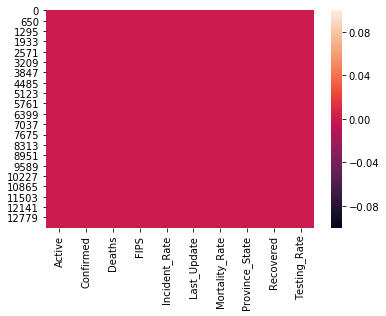

In [9]:
sns.heatmap(df.isnull())
plt.show()

In [10]:
#Checking the datatypes
df.dtypes

Active            float64
Confirmed           int64
Deaths              int64
FIPS              float64
Incident_Rate     float64
Last_Update        object
Mortality_Rate    float64
Province_State     object
Recovered         float64
Testing_Rate      float64
dtype: object

In [11]:
#changing Last_Update into datetime format
df['Last_Update'] =  pd.to_datetime(df['Last_Update'],
                              format='%Y-%m-%d %H:%M:%S')
df['Date'] =  pd.to_datetime(df['Last_Update'],
                              format='%Y-%m-%d')
df['Month'] = pd.DatetimeIndex(df['Date']).month

## DATA VISUALIZATION


### Categorizing the data


In [12]:
#categorizing data with respect to unique provinces/states and creating a new table 

confirmed_by_Province_State = []
death_by_Province_State = [] 
active_by_Province_State = []
recovery_by_Province_State = []
mortality_rate_by_Province_State = [] 

no_cases = []

unique_countries =  list(df['Province_State'].unique())

all_dates = df["Date"]
last_date = all_dates.iat[-1]
total_confirmed_cases =[]


for i in unique_countries:
    active_cases = df[df["Province_State"]==i]["Confirmed"].iloc[-1]
    recovered_cases = df[df["Province_State"]==i]["Recovered"].iloc[-1]
    death_cases = df[df["Province_State"]==i]["Deaths"].iloc[-1]
    if active_cases> 0:
        confirmed_by_Province_State.append(i)
        active_by_Province_State.append(active_cases)
        death_by_Province_State.append(death_cases) 
        recovery_by_Province_State.append(recovered_cases) 
        total_confirmed = death_cases + recovered_cases + active_cases
        total_confirmed_cases.append(total_confirmed)
              
    else :
        no_cases.append(i)  

In [13]:
#Sort by confirmed cases

Province_State_df = pd.DataFrame({'Province_State Name': confirmed_by_Province_State, 'Confirmed': total_confirmed_cases,
                          'Deaths': death_by_Province_State, 'Recovered' : recovery_by_Province_State, 
                          'Active Cases' : active_by_Province_State})
# cases per Province_State/region

Province_State_df.style.background_gradient(cmap='Blues')
sorted = Province_State_df.sort_values('Confirmed', ascending=False)
sorted.style.background_gradient(cmap='Blues')

,Province_State Name,Confirmed,Deaths,Recovered,Active Cases
45,Texas,2.18595e+06,21788,950586,1213577
4,California,1.21974e+06,19116,0,1200624
9,Florida,1.00374e+06,18442,0,985297
33,New York,753890,34514,84938,634438
14,Illinois,725774,12838,0,712936
51,Wisconsin,715233,3464,306770,404999
44,Tennessee,691383,4541,323376,363466
36,Ohio,674434,6378,261353,406703
34,North Carolina,656732,5219,293555,357958
39,Pennsylvania,580695,10234,214516,355945


### BIVARIATE ANALYSIS 

<Figure size 576x432 with 0 Axes>

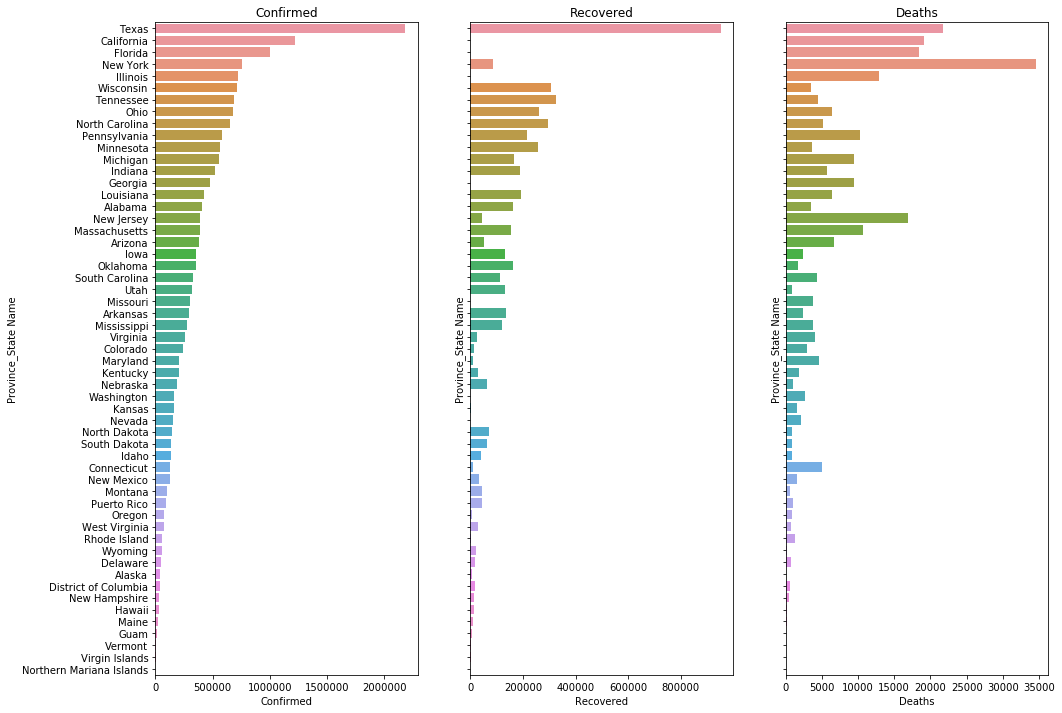

In [14]:
#Plotting Confirmed , Deaths and recovered values statewise
plt.figure(figsize=(8,6))
cols=["Confirmed","Recovered","Deaths"]
fig,axes=plt.subplots(nrows=1,ncols=3,figsize=(16,12),sharey=True)
for i in range(0,len(cols)):
    axes[i] = sns.barplot(y ="Province_State Name", x=cols[i], data=sorted,ax=axes[i])
    axes[i].set_title(cols[i])

##### Observations:
1. Found that Texas has highest number of COVID confirmed cases and recoveries.
2. But highest number of deaths happened in state of NewYork(showing that morbidity rate is higher in New York).
3. Lowest number of COVID cases is 135 in states of Northern Marina Island

In [15]:
#creating database for sum of confirmed case, recovered case and deaths in all the province_state - Datewise

US_cases = []
total_deaths = [] 
recovery_cases = [] 
total_active = [] 
unique_dates = []
total_recovered =[]


dates = df["Date"].unique()

for i in dates:
    death = df[df["Date"]==i]["Deaths"].sum()
    total_deaths.append(death)
    US = df[df["Date"]==i]["Confirmed"].sum()
    US_cases.append(US)
    recovered = df[df["Date"]==i]["Recovered"].sum()
    total_recovered.append(recovered)
    unique_dates.append(i)
    

    
US_cases_df = pd.DataFrame({'Date': dates, 'Confirmed': US_cases,
                          'Deaths': total_deaths, 'Recovered' : total_recovered, 
                          })


US_cases_df.head(10).style.background_gradient(cmap='Blues')


,Date,Confirmed,Deaths,Recovered
0,2020-04-12 23:18:15,555228,22027,34108
1,2020-04-13 23:07:54,559584,23028,35442
2,2020-04-14 00:42:00,21019,499,0
3,2020-04-14 23:33:31,607627,25839,37645
4,2020-04-15 22:56:51,636464,28330,39405
5,2020-04-16 23:30:51,667793,32917,42032
6,2020-04-17 23:30:52,699561,36775,44094
7,2020-04-18 22:32:47,732128,38665,51390
8,2020-04-19 23:41:01,759025,40661,53630
9,2020-04-20 23:36:47,770579,41512,53521


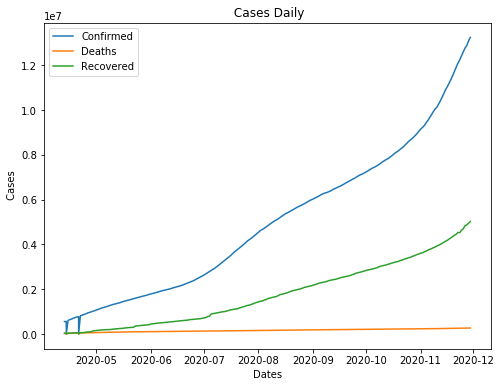

In [16]:
#Plotting US cases daily data
cols = ["Confirmed","Deaths","Recovered"]
plt.figure(figsize=(8,6))
for i in range(0,len(cols)):
    fig = sns.lineplot(x = US_cases_df["Date"],y= US_cases_df[cols[i]])
fig.set_ylabel(' Cases')
fig.set_xlabel('Dates')
plt.title(" Cases Daily")
plt.legend(cols)
plt.show()


##### Observation:
1. With this graph we can deduce that COVID curve has exponential rise and number of active cases (diff b/w confirmed and recovery) is showing an increasing trend also. 

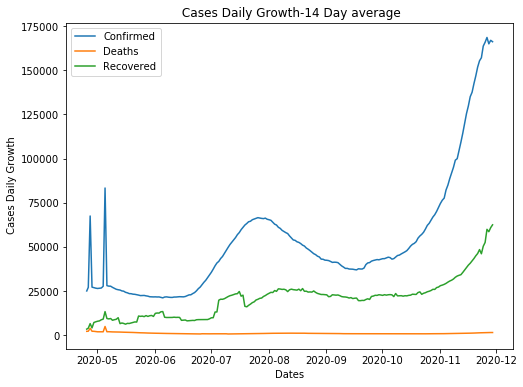

In [17]:
#Plotting US cases daily data with 14 day average data
cols = ["Confirmed","Deaths","Recovered"]

plt.figure(figsize=(8,6))

for i in range(0,len(cols)):
    fig2 = sns.lineplot(x = US_cases_df["Date"],y= US_cases_df[cols[i]].diff().rolling(window=14).mean())

fig2.set_ylabel(' Cases Daily Growth')
fig2.set_xlabel('Dates')
plt.title(" Cases Daily Growth-14 Day average")
plt.legend(cols)
plt.show()


##### Observation:
1. With this graph we can see that first wave of COVID peaked in July-August month of 2020 with ~ 40000 cases/daily.
2. Currently US is facing secondary peak of upto ~120000 cases daily which started in October month. 

<Figure size 576x432 with 0 Axes>

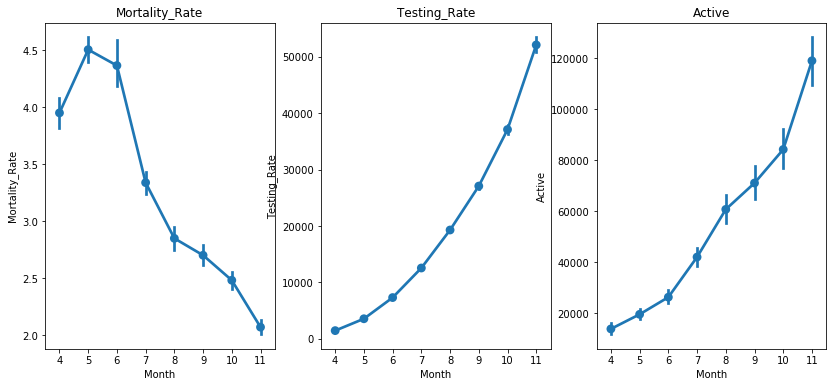

In [18]:
#Plotting mortality , Testing rate and active cases data
plt.figure(figsize=(8,6))
cols=["Mortality_Rate","Testing_Rate","Active"]
fig,axes=plt.subplots(nrows=1,ncols=3,figsize=(14,6))
for i in range(0,len(cols)):
    axes[i] = sns.pointplot(x ="Month", y=cols[i], data=df,ax=axes[i])
    axes[i].set_title(cols[i])


##### Observation:
1. Mortality - Mortality Rate also peaked in July-August month and is continually decreasing.  
2. Testing Rate - Testing Rate is on an exponential rise since beginning of COVID outbreak. 
3. Active Cases - Active Cases started to flatten out after 1st peak in August but is increasing again since Oct.

## Model and Curve Fitting

#### Linear Model

In [19]:
# creating variables for modelling
#future_forecast created for 30 days in future
days_since_start = np.array([i for i in range(len(dates))]).reshape(-1, 1)
US_cases = np.array(US_cases).reshape(-1, 1)
total_deaths = np.array(total_deaths).reshape(-1, 1)
total_recovered = np.array(total_recovered).reshape(-1, 1)

days_in_future = 20
future_forecast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forecast[:-20]

In [34]:
#Breaking our input and target variable into train and test data
from sklearn.model_selection import train_test_split
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_start, US_cases, test_size=0.2, shuffle=False)
model_scores=[]

In [35]:
lin_rg=LinearRegression(normalize=True,fit_intercept=False)
lin_rg.fit(X_train_confirmed,y_train_confirmed)
lin_pred=lin_rg.predict(X_test_confirmed)
line_fut_pred = lin_rg.predict(future_forecast)
model_scores.append(np.sqrt(mean_squared_error(lin_pred, y_test_confirmed)))
print("Root Mean Square Error for Linear Regression: ",np.sqrt(mean_squared_error(lin_pred, y_test_confirmed)))

Root Mean Square Error for Linear Regression:  2335583.2366454853


Text(0.5, 1.0, 'Prediction of Confirmed Cases by Linear Prediction')

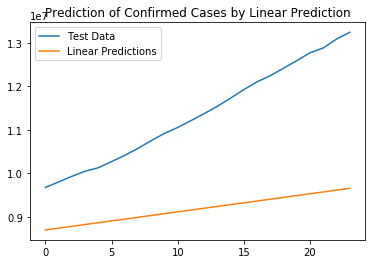

In [36]:
#plotting the difference between prediction model and test data
plt.plot(y_test_confirmed)
plt.plot(lin_pred)
plt.legend(['Test Data', 'Linear Predictions'])
plt.title("Prediction of Confirmed Cases by Linear Prediction")
#Model prediction is close to real test data

#### Observations:
The Linear Regression Model is not appropriate as curve is not matching properly and confirmed cases line is not linear

#### Polynomial Regression model

In [37]:
# transform data for polynomial regression
poly = PolynomialFeatures(degree=5)
poly_X_train_confirmed = poly.fit_transform(X_train_confirmed)
poly_X_test_confirmed = poly.fit_transform(X_test_confirmed)
poly_future_forecast = poly.fit_transform(future_forecast)

In [38]:
# linear regression
linear_poly_model = LinearRegression(normalize=True, fit_intercept=False)
linear_poly_model.fit(poly_X_train_confirmed, y_train_confirmed)
test_poly_pred = linear_poly_model.predict(poly_X_test_confirmed)
poly_pred = linear_poly_model.predict(poly_future_forecast)
model_scores.append(np.sqrt(mean_squared_error(test_poly_pred, y_test_confirmed)))
print("Root Mean Square Error for Linear Regression: ",np.sqrt(mean_squared_error(test_poly_pred, y_test_confirmed)))

Root Mean Square Error for Linear Regression:  562360.0754585827


Text(0.5, 1.0, 'Prediction of Confirmed Cases by Polynomial Prediction')

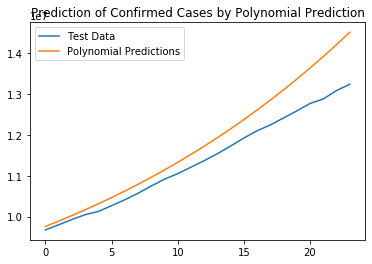

In [39]:
#plotting the difference between prediction model and test data
plt.plot(y_test_confirmed)
plt.plot(test_poly_pred)
plt.legend(['Test Data', 'Polynomial Predictions'])
plt.title("Prediction of Confirmed Cases by Polynomial Prediction")
#Model prediction is close to real test data

#### Observations:
The Polynomial Regression Model is matching closely with the curve and performing much better than the linear prediction model. 

### SVM Model:

In [27]:
# svm_confirmed = svm_search.best_estimator_
svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=5, C=0.1)
svm_confirmed.fit(X_train_confirmed, y_train_confirmed)
svm_pred = svm_confirmed.predict(future_forecast)
svm_test_pred = svm_confirmed.predict(X_test_confirmed)

Root Mean Square Error for Linear Regression:  8827339.426173748


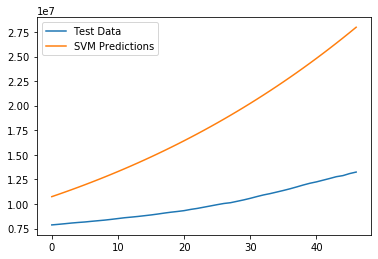

In [28]:
#plotting real test data and SVM plot prediction
svm_test_pred = svm_confirmed.predict(X_test_confirmed)
plt.plot(y_test_confirmed)
plt.plot(svm_test_pred)
plt.legend(['Test Data', 'SVM Predictions'])
model_scores.append(np.sqrt(mean_squared_error(svm_test_pred, y_test_confirmed)))
print("Root Mean Square Error for Linear Regression: ",np.sqrt(mean_squared_error(svm_test_pred, y_test_confirmed)))

#### Observations:
The SVM Regression model is overpredicting and underpredicting values in many places and hence not the best match for our data. 

In [40]:
#defining a plot prediction function 
def plot_predictions(x, y, pred, algo_name, color):
    plt.plot(x, y)
    plt.plot(future_forecast, pred, linestyle='dashed', color=color)
    plt.title(' Coronavirus Cases Over Time', size=10)
    plt.xlabel('Days Since Start', size=10)
    plt.ylabel(' Cases', size=10)
    plt.legend(['Confirmed Cases', algo_name], prop={'size': 10})
    plt.xticks(size=10)
    plt.yticks(size=10)
    plt.show()

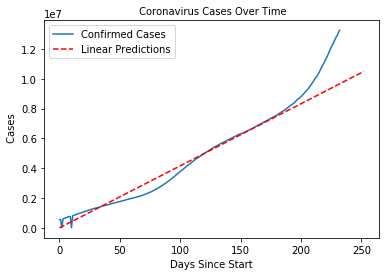

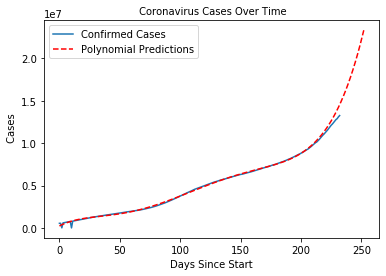

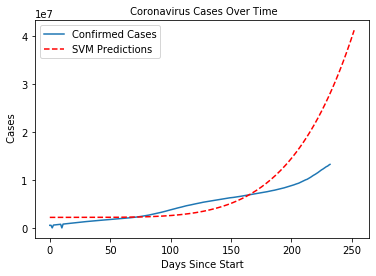

In [41]:
#Plotting data from test and predicted value of Various models
ax1=plot_predictions(adjusted_dates, US_cases, line_fut_pred, 'Linear Predictions', 'red')
ax2=plot_predictions(adjusted_dates, US_cases, poly_pred, 'Polynomial Predictions', 'red')
ax3=plot_predictions(adjusted_dates, US_cases, svm_pred, 'SVM Predictions', 'red')
#Clearly polynomial regression is showing very good acurracy in prediction

In [52]:
#preparing dataset for future dates for prediction

future_forecast_dates = []
start_date = datetime.datetime.strptime("4/14/2020", '%m/%d/%Y')

for i in range(len(dates)):
    future_forecast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [61]:
# Future predictions using polynomial regression
poly_pred = poly_pred.reshape(1,-1)[0]
line_fut_pred=line_fut_pred.reshape(1,-1)[0]
svm_pred = svm_pred.reshape(1,-1)[0]


pred_comp_df = pd.DataFrame({'Date': future_forecast_dates[-20:], 'Predicted  Linear Cases': np.round(line_fut_pred[-20:]),'Predicted  Polynomial Cases': np.round(poly_pred[-20:]),'Predicted  SVM Cases': np.round(svm_pred[-20:])})
pred_comp_df.head()


,Date,Predicted Linear Cases,Predicted Polynomial Cases,Predicted SVM Cases
0,11/13/2020,9693662.0,14831163.0,28538000.0
1,11/14/2020,9735265.0,15155685.0,29107906.0
2,11/15/2020,9776869.0,15491714.0,29687638.0
3,11/16/2020,9818473.0,15839567.0,30277322.0
4,11/17/2020,9860076.0,16199566.0,30877086.0


## Observations for Model Prediction:
1. Best curve fitting is observed with Polynomial regression model with features degree=5
2. Linear model is not an appropriate match because case growth is exponential. 
3. SVM is overpredicting the data for confirmed cases in later stages and hence is not a good match. 
4. So based on graphical and error analysis , we are choosing Polynomial model for making our prediction. 

## Overall Remarks:
1. Retrieved data from online github repository and created a csv file with the data.
2. Dropped irrelevant cols such as (Lat , Long , People tested etc) and imputed missing data in (Recovered and Mortality Rate)
3. With Data Visualization found below observations:
    a. First wave of COVID peaked in July-August month of 2020 with ~ 40000 cases/daily.
    b. Currently US is facing secondary peak of upto ~120000 cases daily which started in October month.
    c. Mortality Rate also peaked in July-August month and is continually decreasing.
    d. Testing Rate is on an exponential rise since beginning of COVID outbreak.
    e. Active Cases started to flatten out after 1st peak in August but is increasing again since Oct
3. For Curve fitting - Linear model , Polynomial model and SVM were evaluated. 
4. Linear Regression model was found to be unfit due to exponential nature of cases growth
5. Found polynomial regression to be the best match with minimum MSE.
6. SVM regression found to be overshooting the values for predicted cases. 
7. Hence, Selected Polynomial curve and predicted the COVID cases for next 20 days. 

In [60]:
#Saving prediction to csv file
poly_pred_df = pd.DataFrame({'Date': future_forecast_dates[-20:],'Predicted  Polynomial Cases': np.round(poly_pred[-20:])})
print(poly_pred_df)
poly_pred_df.to_csv("Covid_Prediction.csv",index=False)

          Date  Predicted  Polynomial Cases
0   11/13/2020                   14831163.0
1   11/14/2020                   15155685.0
2   11/15/2020                   15491714.0
3   11/16/2020                   15839567.0
4   11/17/2020                   16199566.0
5   11/18/2020                   16572039.0
6   11/19/2020                   16957318.0
7   11/20/2020                   17355742.0
8   11/21/2020                   17767654.0
9   11/22/2020                   18193403.0
10  11/23/2020                   18633343.0
11  11/24/2020                   19087835.0
12  11/25/2020                   19557244.0
13  11/26/2020                   20041941.0
14  11/27/2020                   20542303.0
15  11/28/2020                   21058712.0
16  11/29/2020                   21591556.0
17  11/30/2020                   22141229.0
18  12/01/2020                   22708131.0
19  12/02/2020                   23292667.0
